In [1]:
import pandas as pd
import scipy.stats
import re
import statsmodels.api as sm

import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

from sklearn.metrics import roc_curve, auc, roc_auc_score
import numpy as np

from sklearn.metrics import confusion_matrix

import matplotlib as mpl #Some more style nonsense
from matplotlib import pyplot as plt
mpl.rcParams['figure.dpi']=300 # dots per inch

In [2]:
calculatedProperties = pd.read_csv("FH_complete_mutation_summary.csv")
calculatedProperties.head()

,Unnamed: 0,Residue,AAfrom,AAto,rhapsodyscore,rhapsodyclass,polyphenscore,polyphenclass,Foldx_energy,Rosetta_energy,Mutation,average_energy,RSA,Mindist_bindingsiteA,Mindist_hinge
0,0,49,S,A,0.086,neutral,0.00,neutral,0.061363,3.265,S49A,1.663182,0.992308,23.461148,33.7131
1,1,49,S,C,0.535,neutral,0.86,deleterious,0.067352,7.990,S49C,4.028676,0.992308,23.461148,33.7131
2,2,49,S,D,0.052,neutral,0.00,neutral,-0.103203,1.891,S49D,0.893899,0.992308,23.461148,33.7131
3,3,49,S,E,0.049,neutral,0.00,neutral,-0.086741,0.983,S49E,0.448129,0.992308,23.461148,33.7131
4,4,49,S,F,0.529,neutral,0.62,deleterious,0.182080,4.837,S49F,2.509540,0.992308,23.461148,33.7131


In [3]:
calculatedProperties = calculatedProperties.drop(columns = ["Mutation","Unnamed: 0", "rhapsodyclass","rhapsodyscore","polyphenscore","polyphenclass"])
calculatedProperties

,Residue,AAfrom,AAto,Foldx_energy,Rosetta_energy,average_energy,RSA,Mindist_bindingsiteA,Mindist_hinge
0,49,S,A,0.061363,3.265,1.663182,0.992308,23.461148,33.713100
1,49,S,C,0.067352,7.990,4.028676,0.992308,23.461148,33.713100
2,49,S,D,-0.103203,1.891,0.893899,0.992308,23.461148,33.713100
3,49,S,E,-0.086741,0.983,0.448129,0.992308,23.461148,33.713100
4,49,S,F,0.182080,4.837,2.509540,0.992308,23.461148,33.713100
...,...,...,...,...,...,...,...,...,...
8773,510,K,S,0.571362,1.871,1.221181,0.717073,14.891393,15.359364
8774,510,K,T,0.862076,1.330,1.096038,0.717073,14.891393,15.359364
8775,510,K,V,1.125190,-0.576,0.274595,0.717073,14.891393,15.359364
8776,510,K,W,0.686269,-0.158,0.264134,0.717073,14.891393,15.359364


In [4]:
StatisticalScores = pd.read_csv("./FH_mutations_6.csv")

In [5]:
# need to match column names to that of calculatedProperties
StatisticalScores.rename(columns={
    'aapos': 'Residue',
    'aaalt': 'AAto',
    'aaref': 'AAfrom'
}, inplace=True)

StatisticalScores.head()

,pos(1-based),AAto,AAfrom,ref,alt,Residue,HGVSc_VEP,HGVSp_VEP,rs_dbSNP,BayesDel_noAF_score,BayesDel_addAF_score,BayesDel_addAF_rankscore,REVEL_score,REVEL_rankscore,clinvar_clnsig,clinvar_review
0,241497831,N,K,C,A;G,510,c.1530G>C;c.1530G>T,p.Lys510Asn,.;.,0.052162,0.201846,0.73872,0.694,0.88865,.,.;.
1,241497832,M,K,T,A,510,c.1529A>T,p.Lys510Met,.,0.226338,0.323103,0.84583,0.755,0.91594,.,.
2,241497832,R,K,T,C,510,c.1529A>G,p.Lys510Arg,rs2147911174,0.090205,0.228331,0.76389,0.526,0.79842,Uncertain_significance,"criteria_provided,_multiple_submitters,_no_con..."
3,241497832,T,K,T,G,510,c.1529A>C,p.Lys510Thr,.,0.257605,0.344870,0.86065,0.699,0.89099,.,.
4,241497833,E,K,T,C,510,c.1528A>G,p.Lys510Glu,.,0.199121,0.304155,0.83174,0.629,0.85650,Uncertain_significance,"criteria_provided,_single_submitter"


In [6]:
# there's only some tables I want to keep
StatisticalScores = StatisticalScores[["AAfrom","AAto","Residue","REVEL_score","BayesDel_noAF_score","BayesDel_addAF_score"]]

In [7]:
# merging datasets to get ready for binary classification
StatisticalScores_calc = StatisticalScores.merge(calculatedProperties, on = ["Residue", "AAfrom", "AAto"])

In [8]:
bs_calc = StatisticalScores_calc[
    (StatisticalScores_calc['REVEL_score'] <= 0.6488) & 
    (StatisticalScores_calc['BayesDel_noAF_score'] <= 0.1217) & 
    (StatisticalScores_calc['BayesDel_addAF_score'] <= 0.2501)
]

ds_calc = StatisticalScores_calc[
    (StatisticalScores_calc['REVEL_score'] >= 0.6488) & 
    (StatisticalScores_calc['BayesDel_noAF_score'] >= 0.1217) & 
    (StatisticalScores_calc['BayesDel_addAF_score'] >= 0.2501)
]

In [9]:
# converting tables to string to avoid potential errors
bs_calc = bs_calc.astype(str)
ds_calc = ds_calc.astype(str)
#BayesDel_deleterious = BayesDel_deleterious.astype(str)

In [10]:
# add source column to benign and deleterious tables for classification
bs_calc["source"] = "neutral"
ds_calc["source"] = "deleterious"

In [11]:
logreg_data = pd.concat([bs_calc, ds_calc])

logreg_data = pd.get_dummies(logreg_data, columns = ["source"], drop_first = False)

logreg_data

,AAfrom,AAto,Residue,REVEL_score,BayesDel_noAF_score,BayesDel_addAF_score,Foldx_energy,Rosetta_energy,average_energy,RSA,Mindist_bindingsiteA,Mindist_hinge,source_deleterious,source_neutral
2,K,R,510,0.526,0.0902045,0.228331,-0.292345,-0.738,-0.5151725,0.717073171,14.89139297,15.35936366,0,1
5,K,Q,510,0.49,0.0617713,0.208536,0.467419,2.556,1.5117095,0.717073171,14.89139297,15.35936366,0,1
22,L,V,507,0.542,-0.0576501,0.125399,1.88196,2.48,2.18098,0.213414634,15.11647605,6.032148733,0,1
29,D,E,505,0.2675,-0.3454994999999999,-0.0749935499999999,-0.333306,0.777,0.221847,0.63803681,18.71564022,10.63279724,0,1
30,D,A,505,0.439,0.00703723,0.170432,-0.0500161,2.449,1.19949195,0.63803681,18.71564022,10.63279724,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2754,R,P,51,0.891,0.497248,0.511702,3.97582,17.75,10.86291,0.14516129,17.42033636,32.27567249,1,0
2755,R,Q,51,0.928,0.503181,0.515832,2.40467,7.509,4.956835,0.14516129,17.42033636,32.27567249,1,0
2756,R,G,51,0.789,0.438676,0.470926,3.0131,9.092,6.05255,0.14516129,17.42033636,32.27567249,1,0
2757,R,W,51,0.799,0.446505,0.350002,2.569,2.542,2.5555,0.14516129,17.42033636,32.27567249,1,0


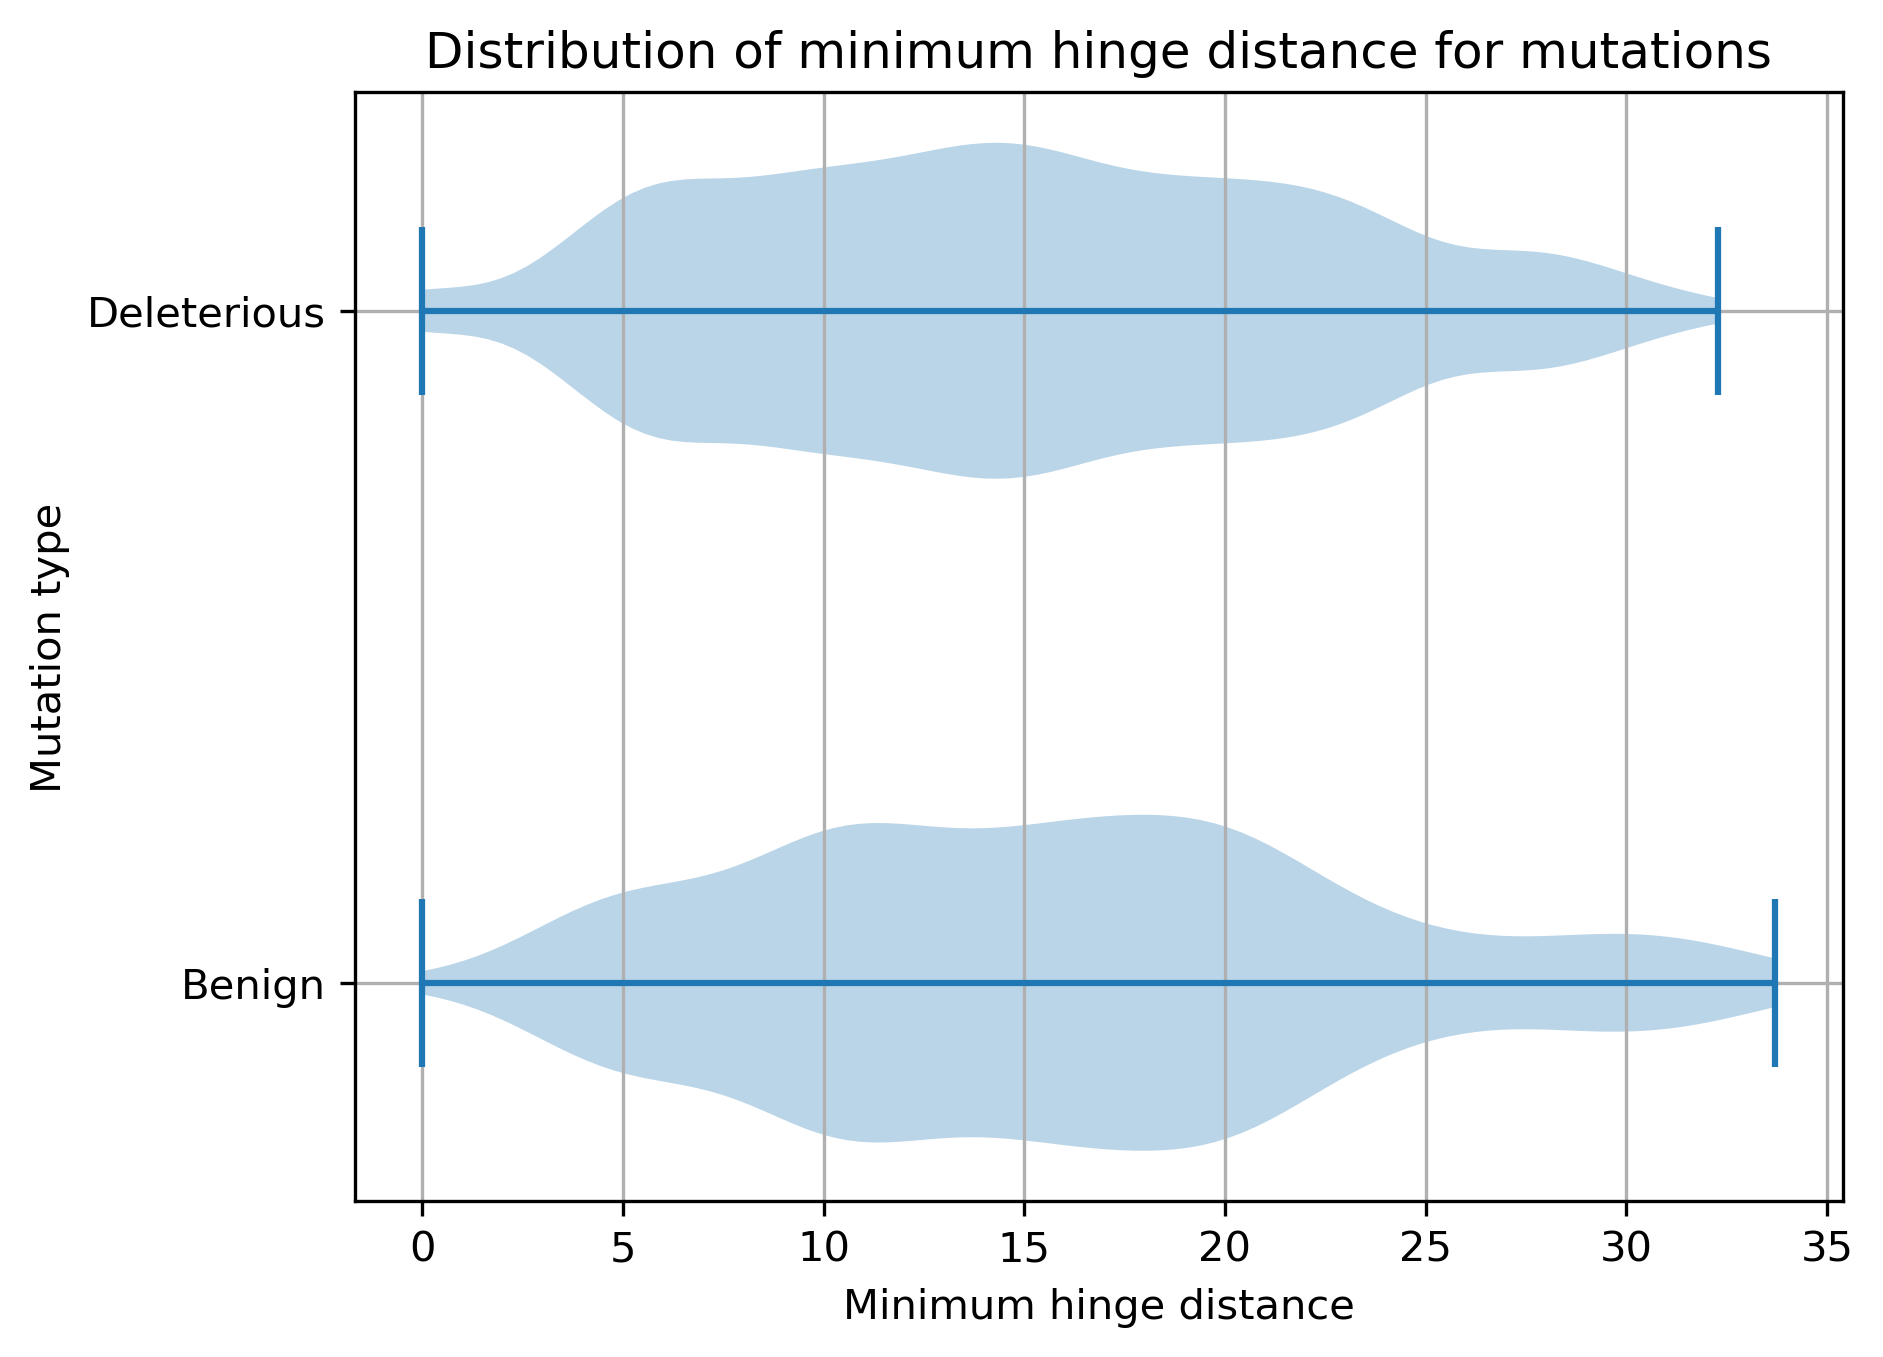

In [12]:
fig, ax = plt.subplots()
# Convert values to float
hinge_distance_benign = bs_calc["Mindist_hinge"].astype(float)
hinge_distance_del = ds_calc["Mindist_hinge"].astype(float)

# Create the violin plot with explicit positions
ax.violinplot([hinge_distance_benign, hinge_distance_del], positions=[1, 2], vert=False)

# Add grid for better visualization
ax.grid()
ax.set_title("Distribution of minimum hinge distance for mutations")

# Set custom labels
ax.set_yticks([1, 2])
ax.set_yticklabels(["Benign", "Deleterious"])

# Add axis labels
ax.set_xlabel("Minimum hinge distance")
ax.set_ylabel("Mutation type")

plt.show()

This is really interesting. It's unlikely I've made a mistake twice. Remember that when I did my ROC analysis using the hinge distance values, our auc values were really poor. Similarly the TPR was also quite bad.

What we can see from this graph is that we really cannot discriminate between the deleterious and benign mutations using the minimum hinge distance as a predictor. Well this was already made clear by the ROC curve but in my opinion this is easier to understand.

I had an idea after this to superimpose the two graphs on eachother so we can easily see where the differences are. Then I remembered that in the Explore gene.ipynb notebook at the end we investigated using KDE plots (kernel density estimates). That one looks more clear so I chose to plot the KDE's instead. 

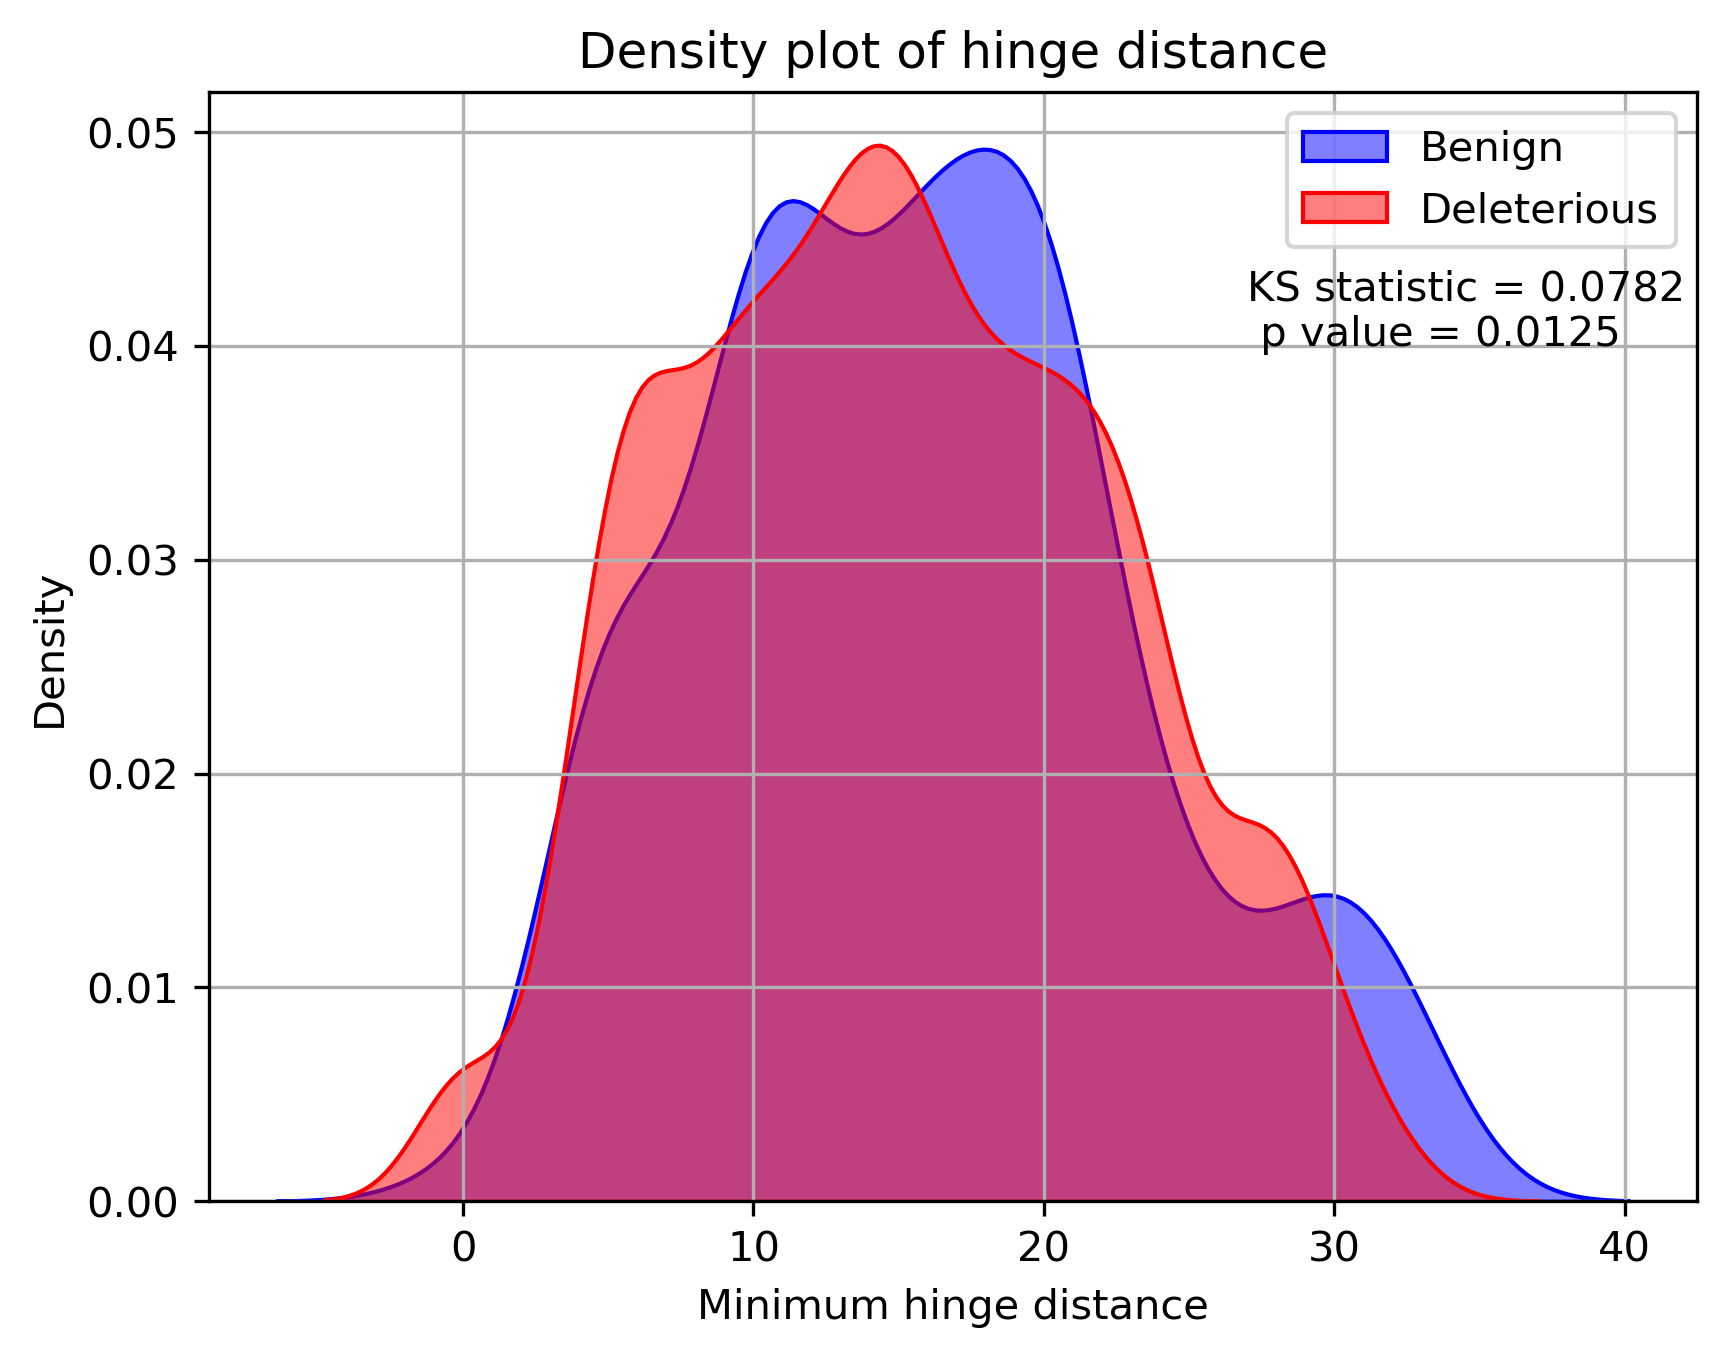

In [73]:
fig, ax = plt.subplots()
# KDE plots for both groups
ax.grid()
sns.kdeplot(hinge_distance_benign, label="Benign", fill=True, color="blue", alpha=0.5)
sns.kdeplot(hinge_distance_del, label="Deleterious", fill=True, color="red", alpha=0.5)

plt.annotate("KS statistic = 0.0782 \n p value = 0.0125", (27,0.04))


# Labels & Title
ax.set_xlabel("Minimum hinge distance")
ax.set_ylabel("Density")
ax.set_title("Density plot of hinge distance")
ax.legend()

plt.show()

In [14]:
##formally test the similarity- ks test is 'conservative' as distribution is discrete

print(scipy.stats.ks_2samp(hinge_distance_benign,hinge_distance_del))

def statistic(x,y,axis):
    return np.median(x,axis)-np.median(y,axis)

print(scipy.stats.permutation_test((hinge_distance_benign,hinge_distance_del),statistic,vectorized=True))

KstestResult(statistic=0.07823261858349578, pvalue=0.01252242485420322)
PermutationTestResult(statistic=0.9898951599999997, pvalue=0.031, null_distribution=array([ 0.        ,  0.06106295, -0.04822183, ...,  0.98557412,
       -0.17528243,  0.35803621]))


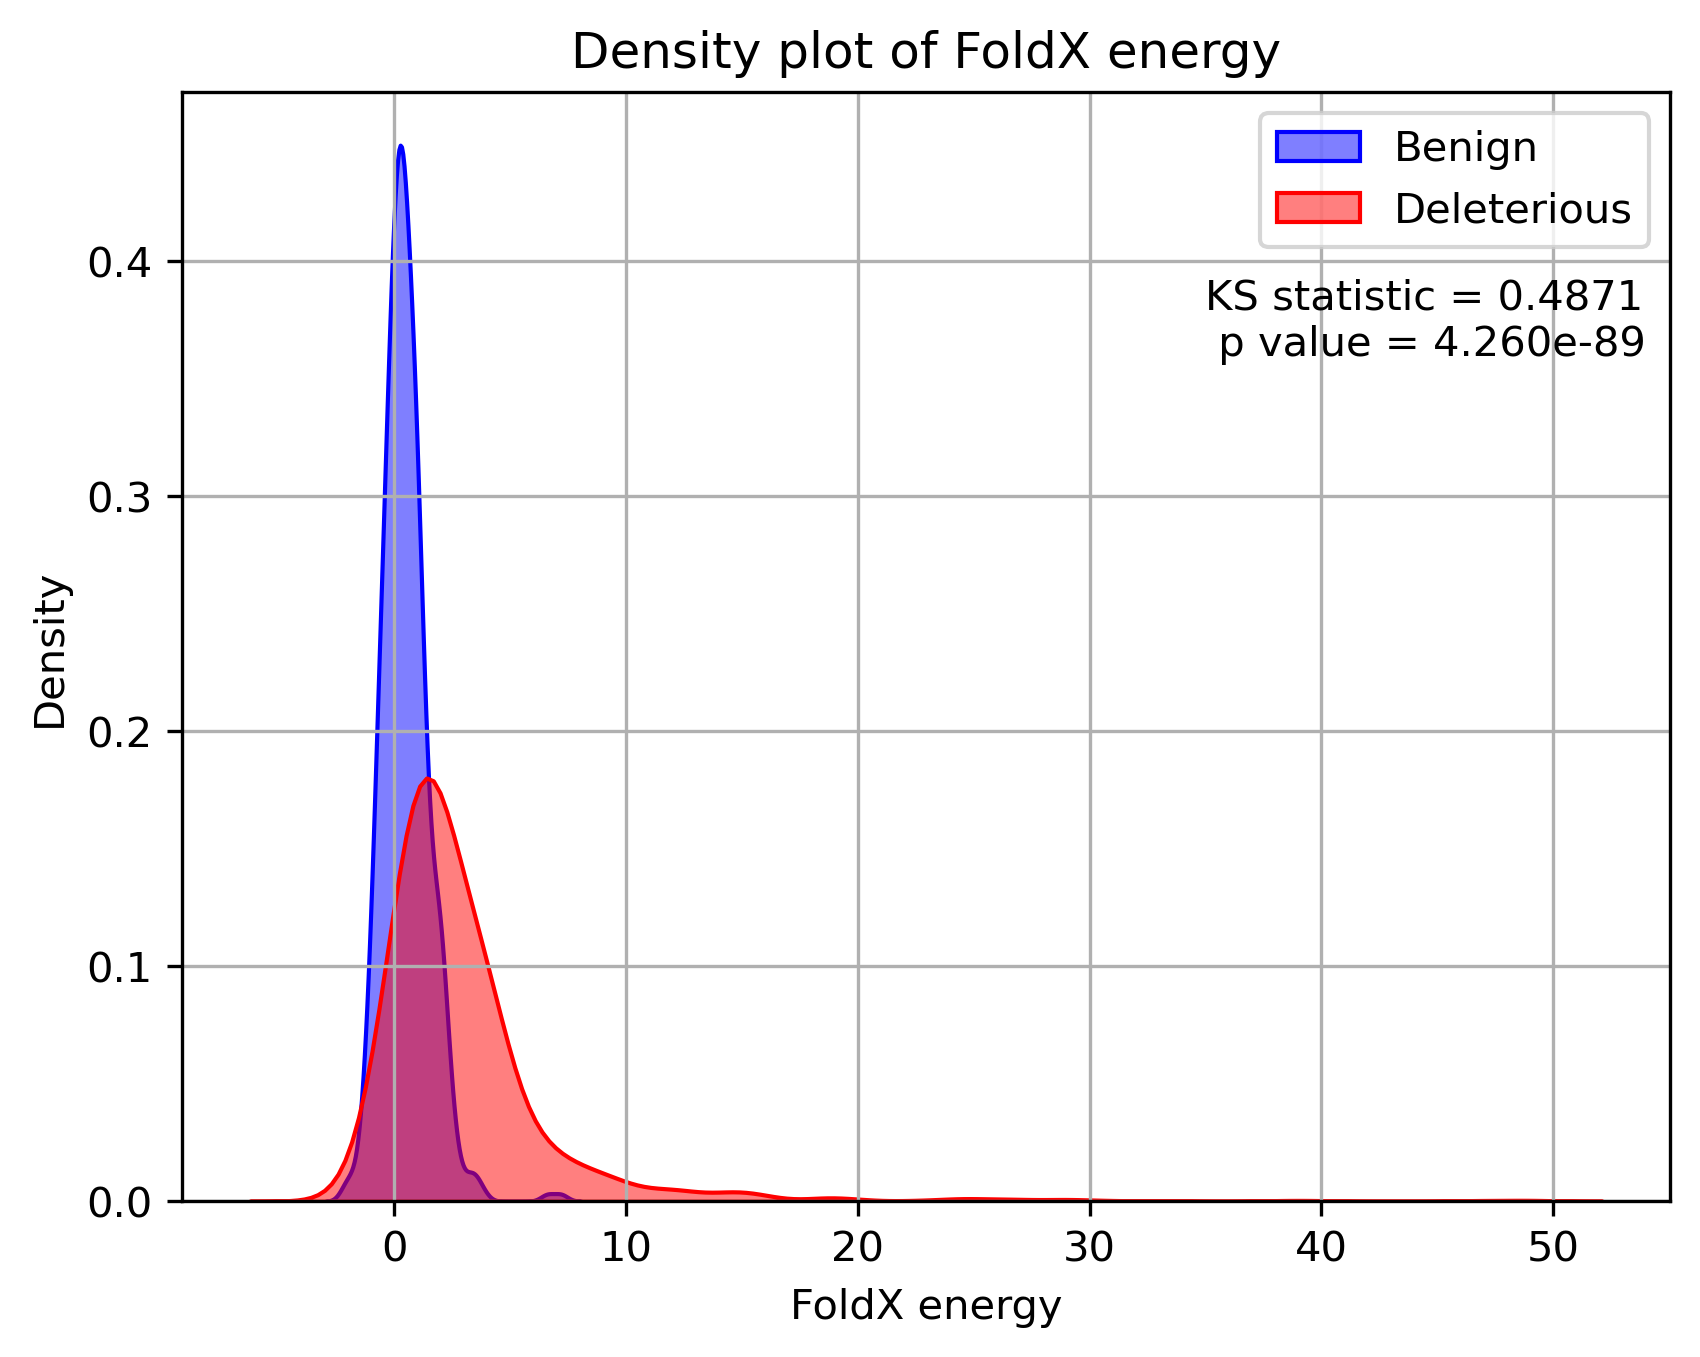

In [67]:
fig, ax = plt.subplots()
# Convert values to float
energy_benign = bs_calc["Foldx_energy"].astype(float)
energy_del = ds_calc["Foldx_energy"].astype(float)

# KDE plots for both groups
sns.kdeplot(energy_benign, label="Benign", fill=True, color="blue", alpha=0.5)
sns.kdeplot(energy_del, label="Deleterious", fill=True, color="red", alpha=0.5)

plt.annotate("KS statistic = 0.4871 \n p value = 4.260e-89", (35,0.36))

# Labels & Title
ax.set_xlabel("FoldX energy")
ax.set_ylabel("Density")
ax.set_title("Density plot of FoldX energy")
ax.legend()
ax.grid()
plt.show()

In [16]:
##formally test the similarity- ks test is 'conservative' as distribution is discrete

print(scipy.stats.ks_2samp(energy_benign,energy_del))

def statistic(x,y,axis):
    return np.median(x,axis)-np.median(y,axis)

print(scipy.stats.permutation_test((energy_benign,energy_del),statistic,vectorized=True))

KstestResult(statistic=0.48712150747238464, pvalue=4.259772361235211e-89)
PermutationTestResult(statistic=-1.668958, pvalue=0.0002, null_distribution=array([-0.08313, -0.17911, -0.09759, ..., -0.00879,  0.13258,  0.09296]))


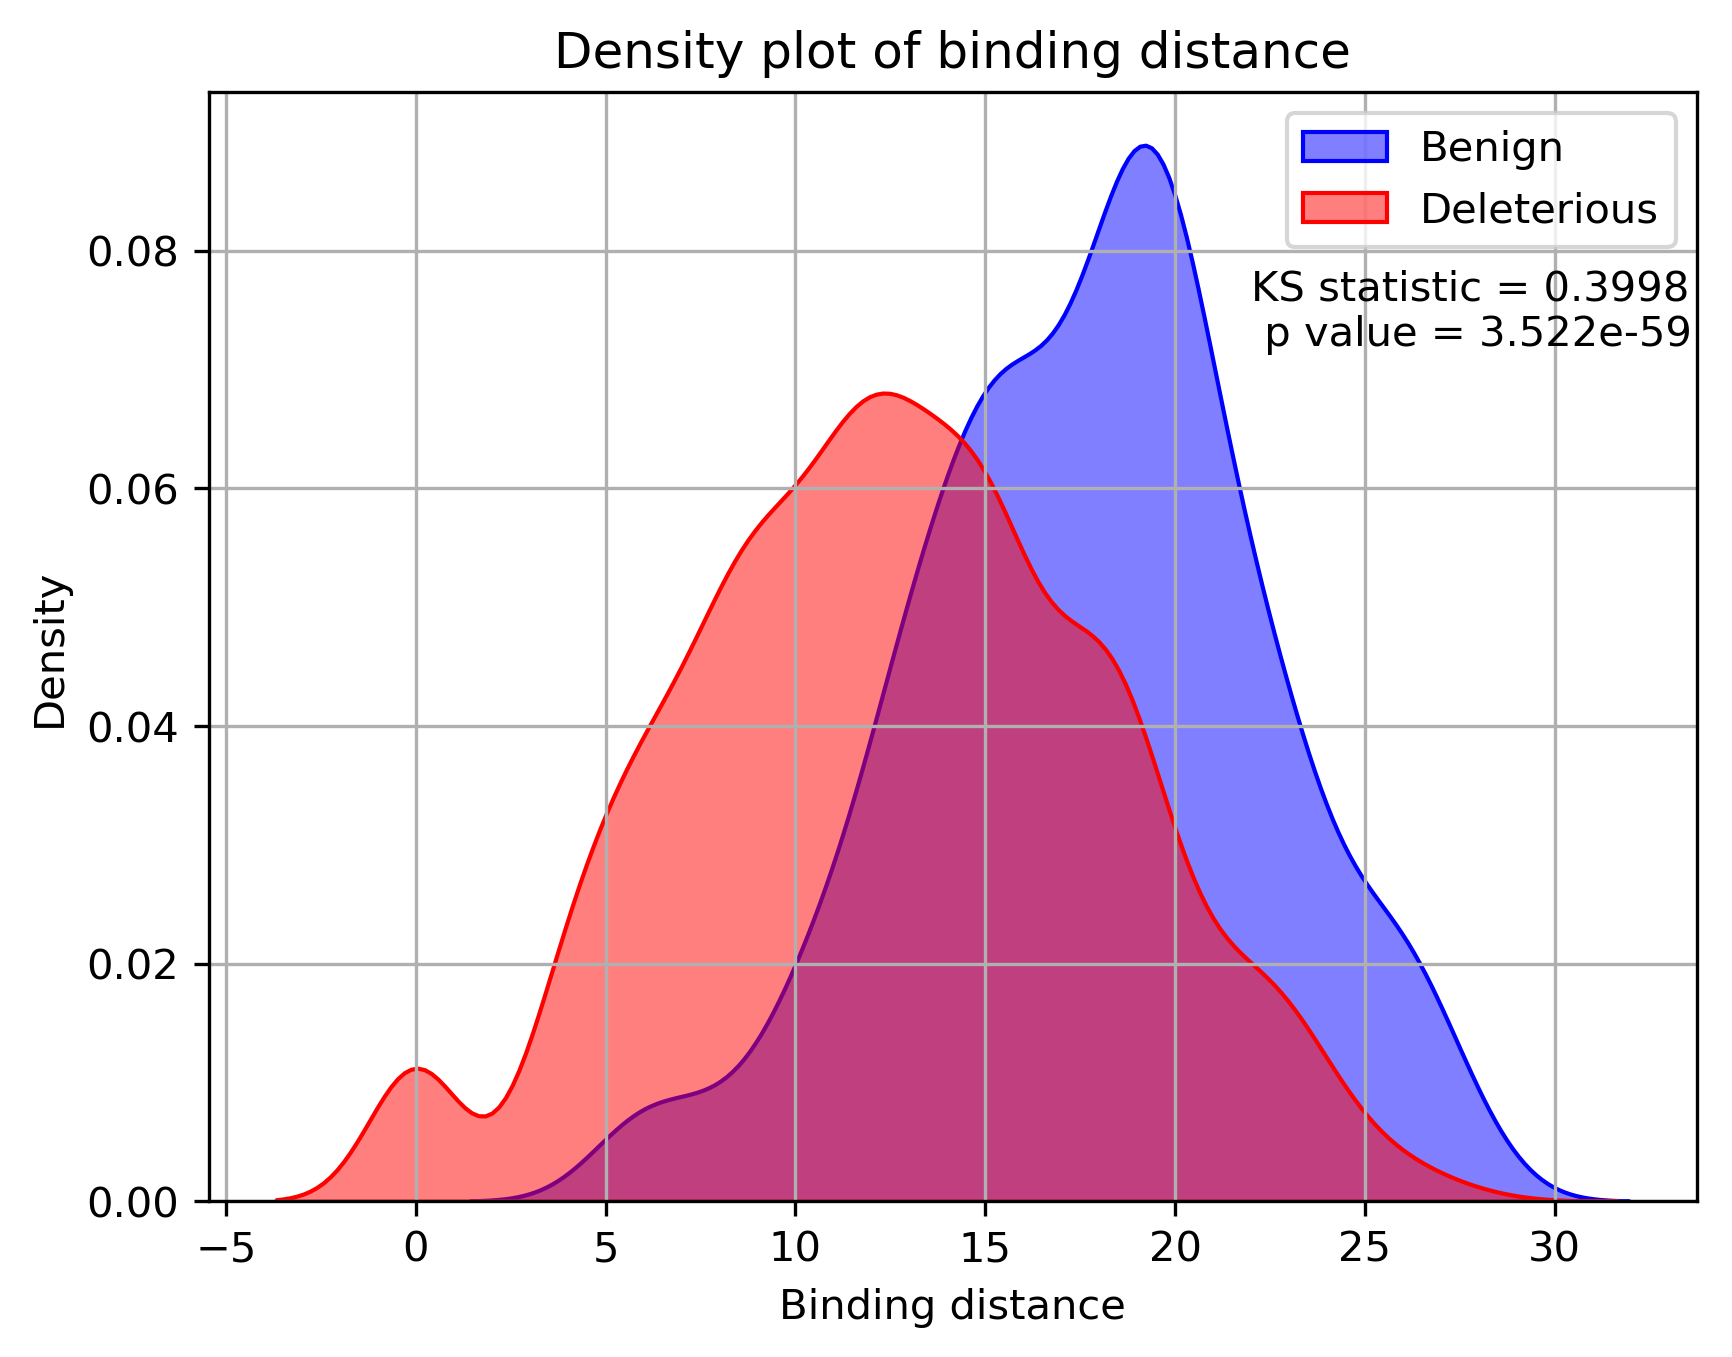

In [63]:
fig, ax = plt.subplots()
# Convert values to float
binding_distance_benign = bs_calc["Mindist_bindingsiteA"].astype(float)
binding_distance_del = ds_calc["Mindist_bindingsiteA"].astype(float)

# KDE plots for both groups
sns.kdeplot(binding_distance_benign, label="Benign", fill=True, color="blue", alpha=0.5)
sns.kdeplot(binding_distance_del, label="Deleterious", fill=True, color="red", alpha=0.5)

plt.annotate("KS statistic = 0.3998 \n p value = 3.522e-59", (22,0.072))

# Labels & Title
ax.set_xlabel("Binding distance")
ax.set_ylabel("Density")
ax.set_title("Density plot of binding distance")
ax.legend()
ax.grid()
plt.show()

In [18]:
##formally test the similarity- ks test is 'conservative' as distribution is discrete

print(scipy.stats.ks_2samp(binding_distance_benign,binding_distance_del))

def statistic(x,y,axis):
    return np.median(x,axis)-np.median(y,axis)

print(scipy.stats.permutation_test((binding_distance_benign,binding_distance_del),statistic,vectorized=True))

KstestResult(statistic=0.39979207277452894, pvalue=3.521919294349867e-59)
PermutationTestResult(statistic=5.504614830000001, pvalue=0.0002, null_distribution=array([ 0.35313436,  0.47699309,  0.95425061, ..., -0.33339954,
       -0.53565295,  0.47699309]))


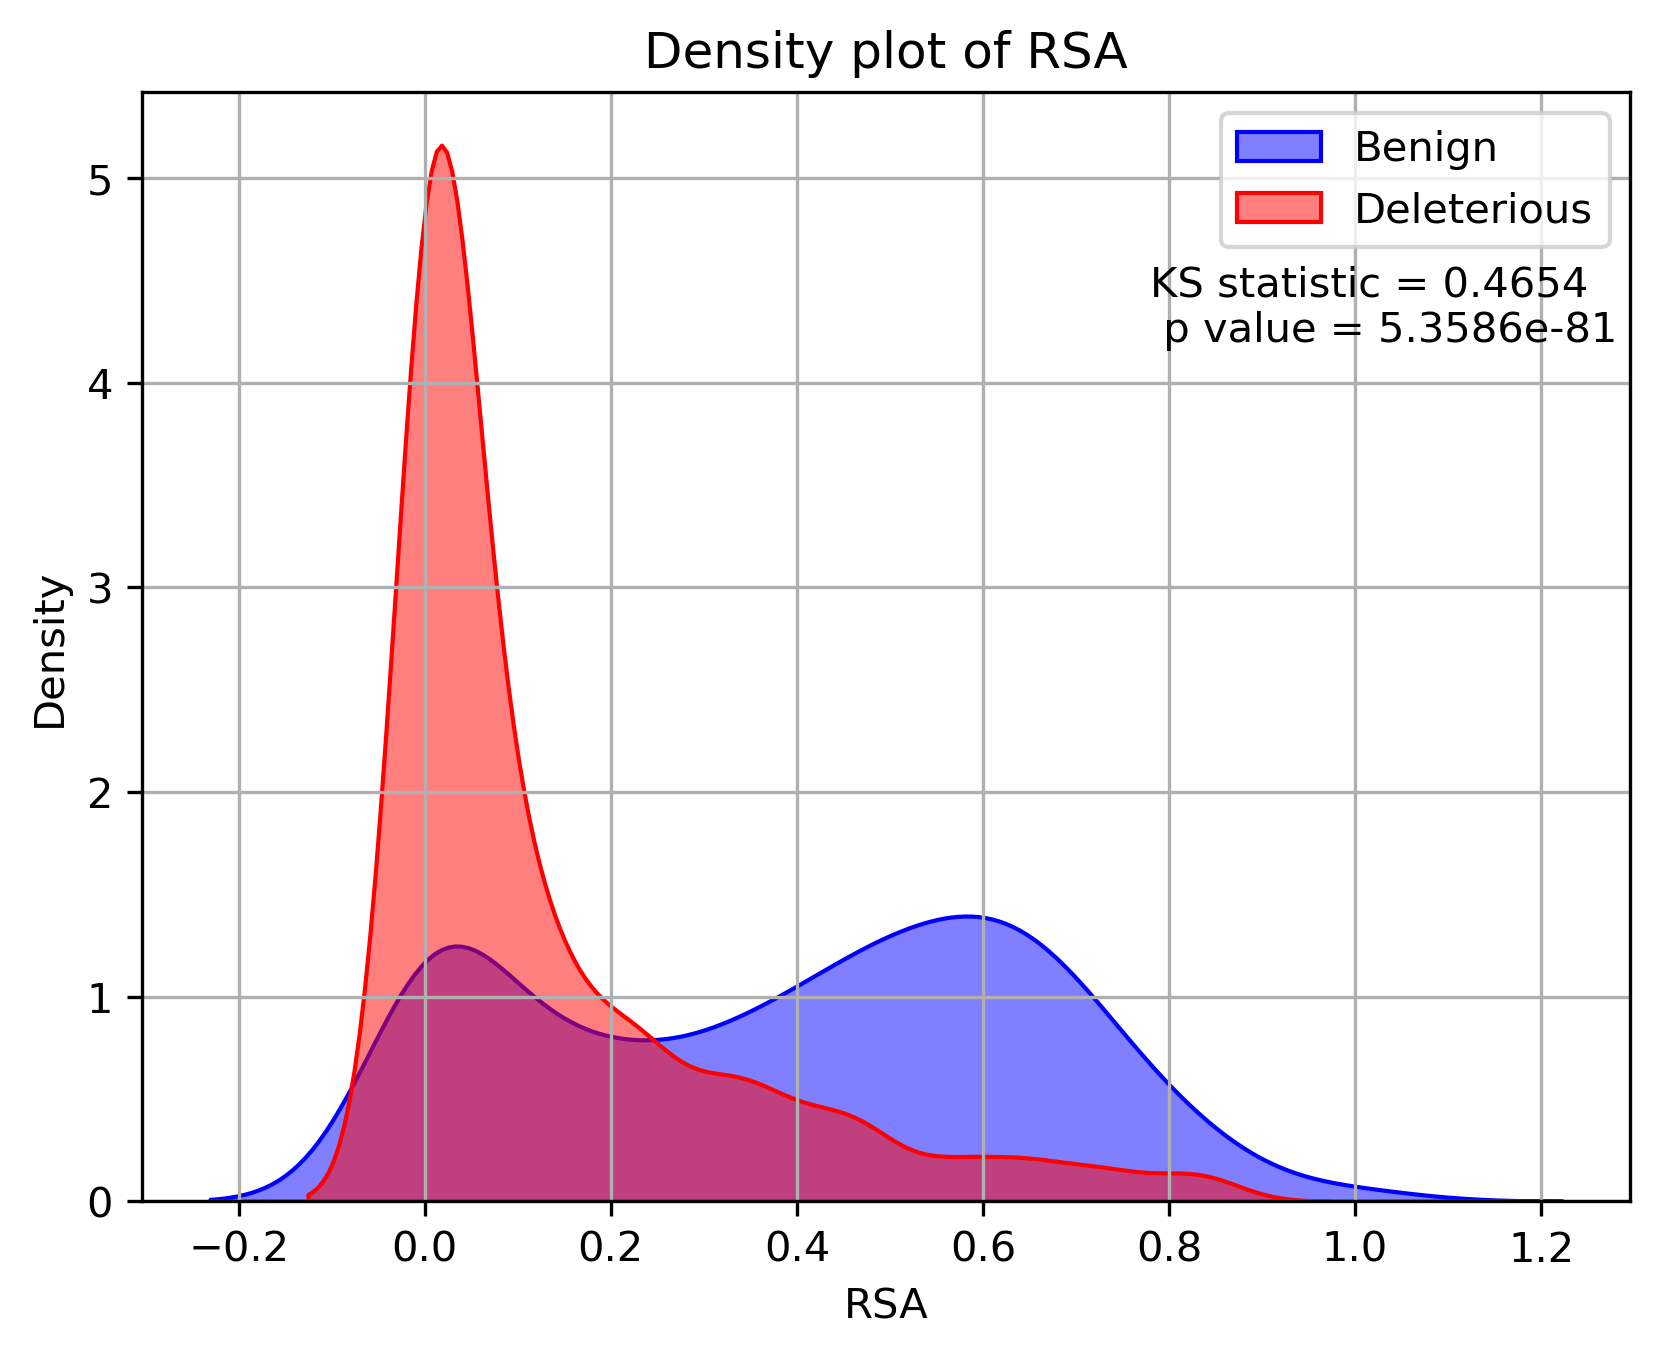

In [59]:
fig, ax = plt.subplots()
# Convert RSA values to float
RSA_benign = bs_calc["RSA"].astype(float)
RSA_del = ds_calc["RSA"].astype(float)

# KDE plots for both groups
sns.kdeplot(RSA_benign, label="Benign", fill=True, color="blue", alpha=0.5)
sns.kdeplot(RSA_del, label="Deleterious", fill=True, color="red", alpha=0.5)

plt.annotate("KS statistic = 0.4654 \n p value = 5.3586e-81", (0.78,4.2))

# Labels & Title
ax.set_xlabel("RSA")
ax.set_ylabel("Density")
ax.set_title("Density plot of RSA")
ax.legend()
ax.grid()
plt.show()

In [20]:
##formally test the similarity- ks test is 'conservative' as distribution is discrete

print(scipy.stats.ks_2samp(RSA_benign,RSA_del))

def statistic(x,y,axis):
    return np.median(x,axis)-np.median(y,axis)

print(scipy.stats.permutation_test((RSA_benign,RSA_del),statistic,vectorized=True))

KstestResult(statistic=0.4653931124106563, pvalue=5.3585943987498325e-81)
PermutationTestResult(statistic=0.388968328, pvalue=0.0002, null_distribution=array([ 0.0168025 , -0.00704225,  0.02241148, ..., -0.0012736 ,
       -0.00979045, -0.01219512]))


This KDE plot of the RSA really drives home our finding that the RSA is the best discriminator between deleterious and benign mutations.

However, this raises a question. We can see from the KDE plots that the hinge distance is by far the worst discriminator. Because there is a lot of overlap between the blue and red graphs. Despite this, what I found was that the RSA and the hinge distance had a very strong negative correlation.
**That's because the correlation matrix actually gives us the correlation between the coefficients and not the actual parameters themselves!**

Another way I can visualise this is by superimposing the violin plots above on eachother.

Below I got help from ChatGPT to improve the presentability of the plot. Unfortunately `ax.violinplot` does not support labelling.

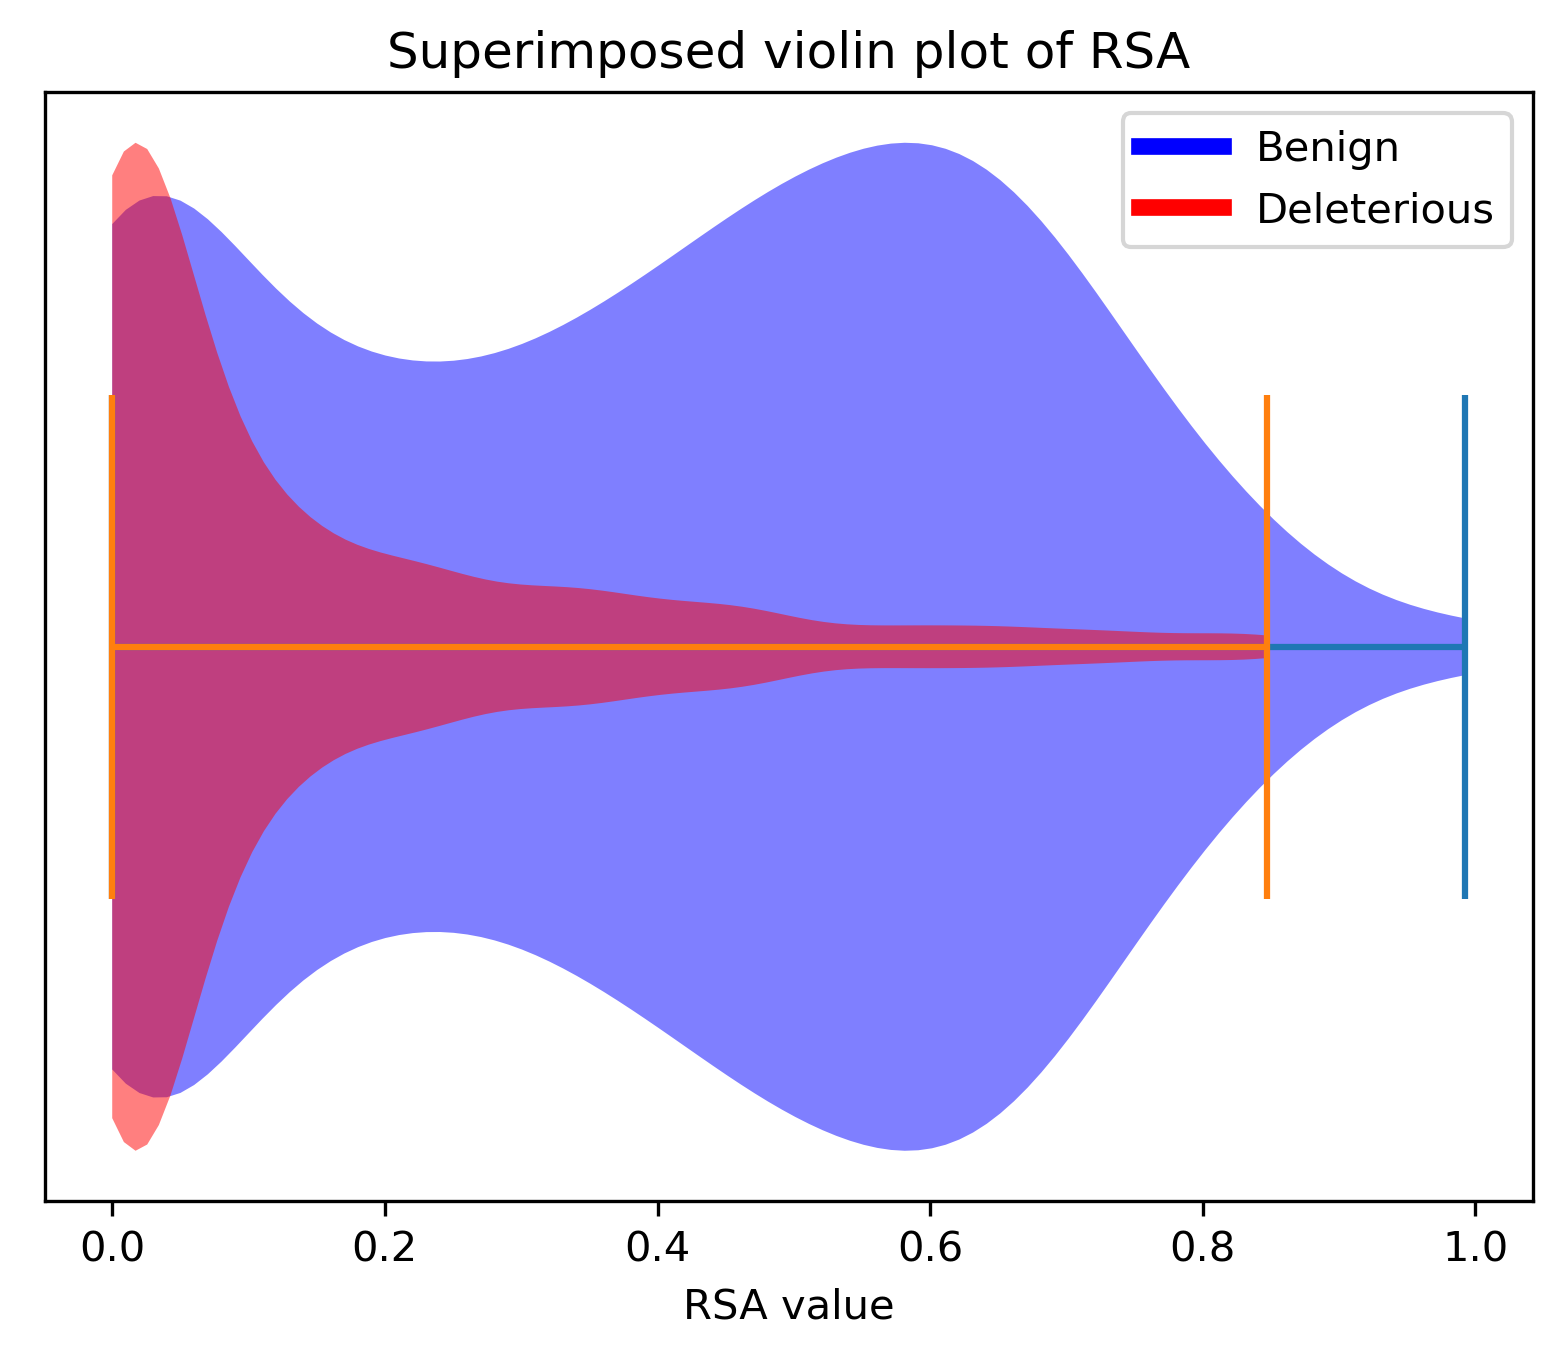

In [21]:
fig, ax = plt.subplots()
# Create violin plots at the same position (so they overlap)
violin1 = ax.violinplot([RSA_benign], positions=[1], vert=False)
violin2 = ax.violinplot([RSA_del], positions=[1], vert=False)

# Customize colors manually (Violin plots don't accept `label`)
for part in violin1['bodies']:
    part.set_facecolor('blue')  # Set benign color
    part.set_alpha(0.5)  # Transparency

for part in violin2['bodies']:
    part.set_facecolor('red')  # Set deleterious color
    part.set_alpha(0.5)

# Add a legend manually
legend_patches = [
    plt.Line2D([0], [0], color='blue', lw=4, label='Benign'),
    plt.Line2D([0], [0], color='red', lw=4, label='Deleterious')
]
ax.legend(handles=legend_patches, loc="upper right")

# Labels & Title
ax.set_xlabel("RSA value")
ax.set_yticks([])  # Remove y-ticks (since both are at position 1)
ax.set_title("Superimposed violin plot of RSA")

plt.show()


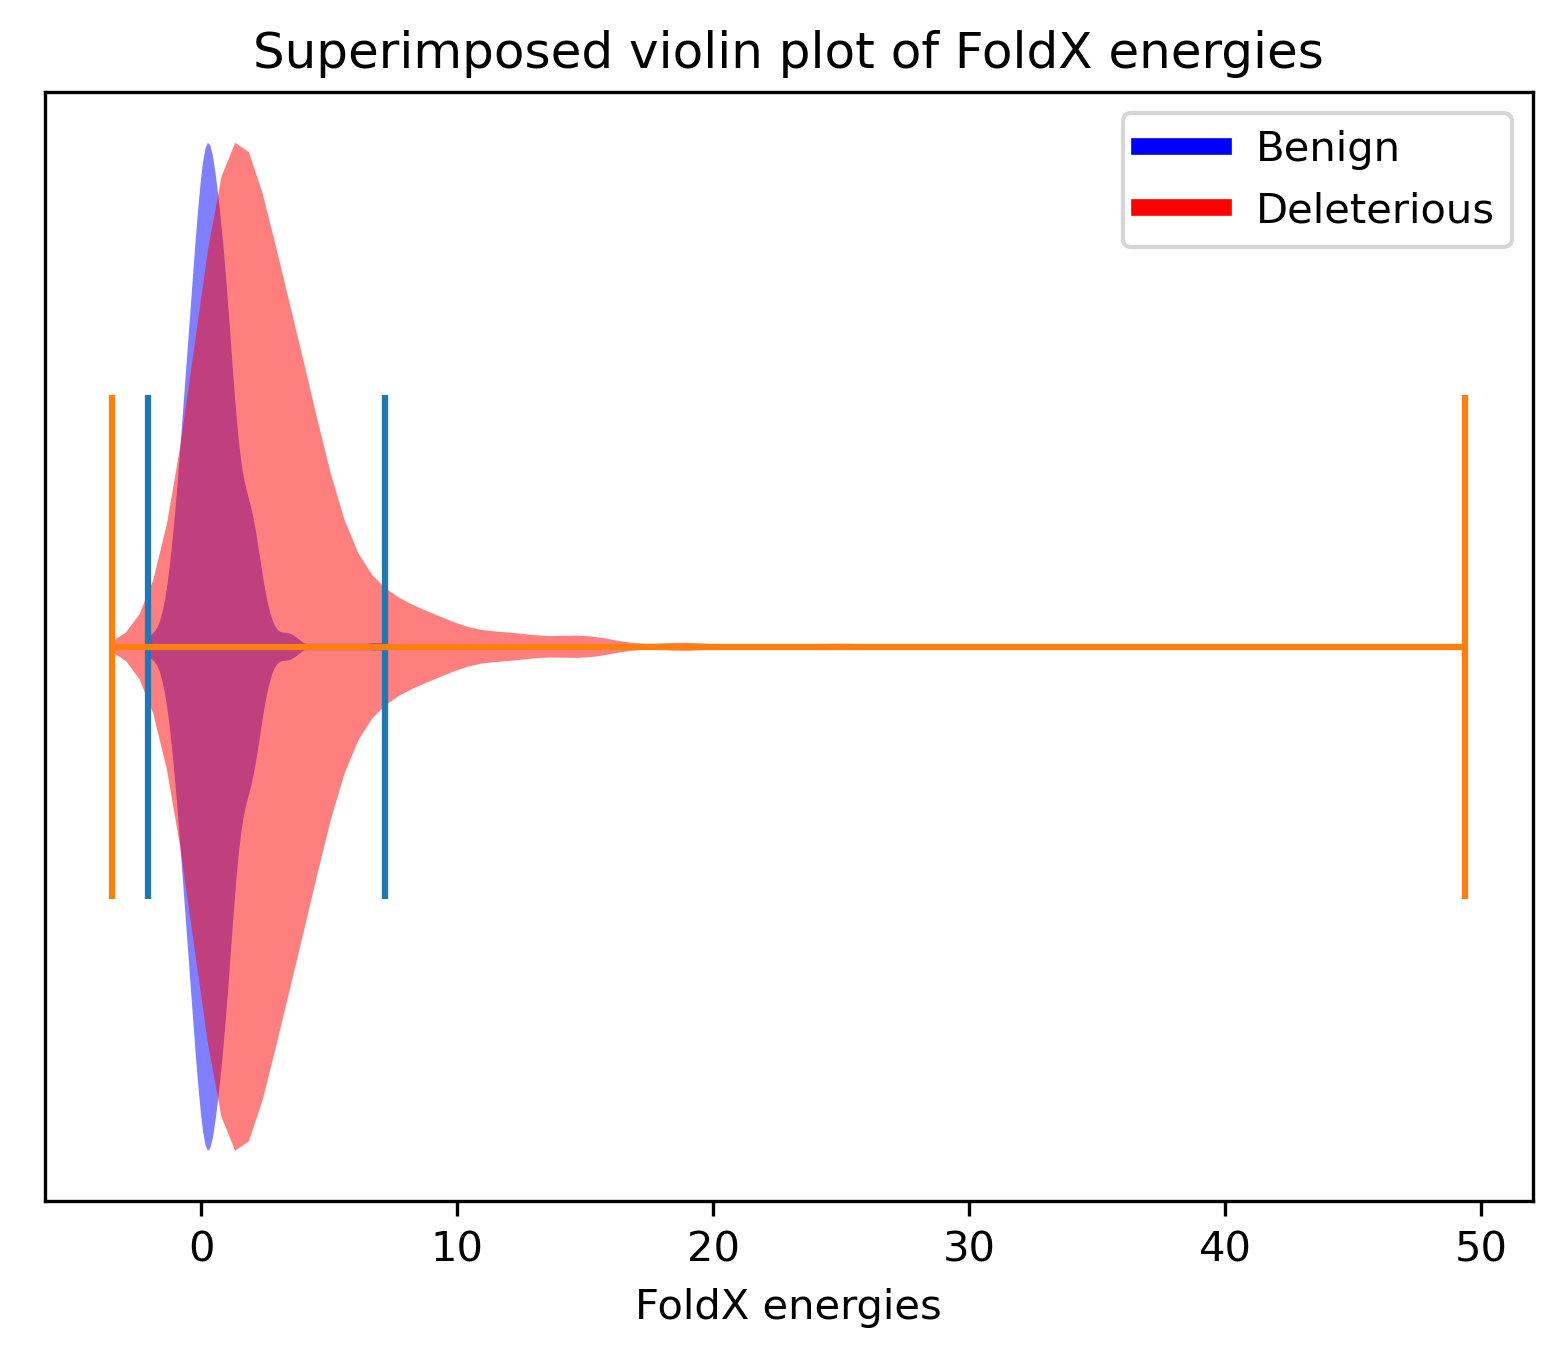

In [22]:
fig, ax = plt.subplots()
## Create violin plots at the same position (so they overlap)
violin1 = ax.violinplot([energy_benign], positions=[1], vert=False)
violin2 = ax.violinplot([energy_del], positions=[1], vert=False)

# Customize colors manually (Violin plots don't accept `label`)
for part in violin1['bodies']:
    part.set_facecolor('blue')  # Set benign color
    part.set_alpha(0.5)  # Transparency

for part in violin2['bodies']:
    part.set_facecolor('red')  # Set deleterious color
    part.set_alpha(0.5)

# Add a legend manually
legend_patches = [
    plt.Line2D([0], [0], color='blue', lw=4, label='Benign'),
    plt.Line2D([0], [0], color='red', lw=4, label='Deleterious')
]
ax.legend(handles=legend_patches, loc="upper right")

# Labels & Title
ax.set_xlabel("FoldX energies")
ax.set_yticks([])  # Remove y-ticks (since both are at position 1)
ax.set_title("Superimposed violin plot of FoldX energies")

plt.show()